In [6]:
# import MODULES
import numpy as np
import matplotlib.pyplot as plt
import xarray as xray
from glob import glob
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs
from matplotlib.cm import get_cmap
from datetime import datetime
from netCDF4 import Dataset,MFDataset
#from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim, ALL_TIMES, geo_bounds
import cmaps
import matplotlib.patches as mpatches
#import scipy.stats as st
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
#import wrf
import sys
#wrf.omp_enabled()
import pandas as pd
import matplotlib
#import seaborn as sns
#sns.set_style('whitegrid')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [7]:
def spatial_plot(ax,lat,lon,dat,cart,ran,cmpi,title):
    
    resol_N = [[75,90],[23,30],['1971-1-1','2010-12-31'],'N_box']
    resol_S = [[73,81],[14,22],['1971-1-1','2010-12-31'],'S_box']
    plotpath = '/home/kaushik/Desktop/plots_spatial/'
    
    # Mollweide
    dmin=ran[0]
    dmax = ran[-1]
    #    dmin=-1*np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    #    dmax=np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    print([dmin,dmax])
    pmesh = ax.pcolormesh(lon,lat,dat,vmin=dmin,vmax=dmax,transform=ccrs.PlateCarree(),cmap=cmpi)
    #pmesh = ax.contourf(lon,lat,dat,np.linspace(dmin,dmax,18),transform=ccrs.PlateCarree(),cmap=cmpi,extend = 'both')
    #pmesh = ax.pcolormesh(lon,lat,dat,transform=ccrs.PlateCarree(),cmap=cmpi)
    ax.coastlines(resolution='10m')
    #ax.add_patch(mpatches.Rectangle(xy=[resol_N[0][0], resol_N[1][0]], width=resol_N[0][1]-resol_N[0][0], height=resol_N[1][1]-resol_N[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    #ax.add_patch(mpatches.Rectangle(xy=[resol_S[0][0], resol_S[1][0]], width=resol_S[0][1]-resol_S[0][0], height=resol_S[1][1]-resol_S[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    fname = '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor='none',edgecolor='black')
    ax.add_feature(shape_feature)
    plt.title(title)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator([45,60,75,90,105,120])
    gl.ylocator = mticker.FixedLocator([-25,-10, 5, 20, 35,50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #plt.savefig(plotpath+title+'_JA_diff.png',bbox_inches='tight',dpi=300)
    #plt.clf()
    #plt.close('all')
    return ax,pmesh,gl

In [8]:
import geopandas as gpd
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan)
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords,
                               longitude='lon', latitude='lat')

    return xr_da


def reg_sel():
    # Region Def.
    resol = {}
    resol['R1'] = [[72.5,81],[33,38]]
    #resol['R2'] = [[75,81,81,88,88,75],[33,33,28,28,24,24]]
    resol['R2'] = [[75,88],[24,33]]
    resol['R3'] = [[88,98],[22,30]]
    resol['R4'] = [[68,75],[22,30]]
    resol['R5'] = [[75,88],[17,24]]
    resol['R6'] = [[72,81],[8,17]]
    resol['ind'] = [[65,95],[5,45]]

    resol['IGP'] = [[75,83],[23,28]]#,['1971-1-1','2010-12-31'],'N_box']
    resol['EI'] = [[85,90],[20,25]]
    resol['S'] = [[73,81],[14,22]]
    resol['D'] = [[67+2,73+2],[23-2,30-2]]
    return resol



In [9]:
import scipy.stats as st
import pandas as pd
from collections import OrderedDict


def calc_PCC(WRF, OBS):
    return np.round(st.pearsonr(WRF,OBS)[0],2)
def calc_RMSE(WRF, OBS):
    return np.round(np.sqrt(((WRF - OBS)**2).mean()).data,2)
def calc_NMSE(WRF, OBS):
    return np.round((((WRF - OBS)**2).mean()/(WRF.mean() * OBS.mean())).data *100,1)
def calc_NMB(WRF, OBS):
    return np.round(((WRF - OBS).sum()/OBS.sum()).data*100,2)
def func_tp(tperiod):
    tslice = {}
    tslice['seas_std'] = ['MAM','DJF','JJA','SON']
    tslice['seas'] = ['JJAS','ON']
    tslice['Annual'] = ['Annual']
    tslice['months'] = list(np.linspace(1,12,12))
    for j in tslice.items():
        if tperiod in j[1]:
            tslice = j[0]
        else:
            print('')
    return tslice                

def regionX(dset,reg):
    resol = reg_sel()
    data = dset.sel(lat=slice(resol[reg][1][0], resol[reg][1][1]),lon=slice(resol[reg][0][0], resol[reg][0][1]))
    return data
def timeX(dset,tperiod):
    ts = func_tp(tperiod)
    if ts == 'seas_std':
        data = dset.sel(time = dset['time.season'] == tperiod)
    elif ts == 'Annual':
        data = dset.sel(time = dset['time.year'] == 2015)
    elif ts == 'months':
        data = dset.sel(time = dset['time.month'] == tperiod)
    elif (ts == 'seas') & (tperiod == 'JJAS'):
        data = dset.sel(time = (dset['time.month']>=6) & (dset['time.month']<=9))
    elif (ts == 'seas') & (tperiod == 'ON'):
        data = dset.sel(time = (dset['time.month']>=10) & (dset['time.month']<=11))
    else:
        print('invalid time period')
    return data
def indshp(dset):
    add_shape_coord_from_data_array(dset, '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp', 'ind')
    data = dset.where(dset.ind==0)
    return data
def tsX(dset,region='R1',tperiod='MAM'):
    data = timeX(indshp(regionX(dset,region)),tperiod)
    data = data.mean(['lat','lon']).resample(time='1D').mean()
    return data

def calc_stats(model_dset,obs_dset,region='R3',tperiod='MAM',obs_name='MODIS',scale=1):
    STATS = {}
    WRF = tsX(model_dset,region,tperiod)*scale
    OBS = tsX(obs_dset,region,tperiod)
    
    STATS['PCC'] = calc_PCC(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMB'] = calc_NMB(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['RMSE'] = calc_RMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMSE'] = calc_NMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['O'] = np.round(OBS[np.isfinite(OBS)].mean().data,3)
    STATS['M'] = np.round(WRF[np.isfinite(OBS)].mean().data,3)
    return STATS

In [10]:
def ext_WRF(vname,dmap):
    import dask
    dset_WRF = []
    for fl in dmap:
        REL_PATH = '/mnt/nas/DATA/kaushik/proc/'+fl+'/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/'+'1hr'+'/'+vname+'/gn/'
        flist = sorted(glob(REL_PATH+'*2015*'))
        print(flist,'END')
        dset_base = xray.concat([xray.open_dataset(f,chunks={'time':10})[vname] for f in flist],'time')
        dset_WRF.append(dset_base)

    dset_WRF = xray.concat(dset_WRF,pd.Index(dmap,name='exp'))
    return dset_WRF

In [9]:


from dask.diagnostics import ProgressBar

ranspec= {} 
ranspec['sconcdust'] = [0,100]
ranspec['sconcso4'] = [0,10]
ranspec['sconcpoa'] = [0,40]
ranspec['sconcbc'] = [0,10]
ranspec['sconcnh4'] = [0,12]
ranspec['sconcno3'] = [0,30]
ranspec['sconcna'] = [0,5]
ranspec['sconccl'] = [0,5]
ranspec['sconcsoa'] = [0,2]

dmap = ['processed','NoARI']
with pd.ExcelWriter('Dust_contribution.xlsx') as writer:
    exp_dict = {}
    for reg in ['R1','R2','R3','R4','R5','R6','ind']:
        for exp in range(2):
            mon_dict = {}
            x = list(np.arange(1,13,1))
            x.extend(['DJF','MAM','JJAS','ON'])
            x.append('Annual')
            for mon in x:
                dset_WRF = xray.concat([tsX(ext_WRF(vname),region = reg,tperiod=mon).isel(exp=exp) for vname in ranspec.keys()],pd.Index(ranspec.keys(),name='spec'))                
                mon_dict[mon] = dset_WRF.compute()
                #x = dset_WRF.sel(spec='sconcdust').mean()/((dset_WRF.sum('spec').mean('time')).data)
                #with ProgressBar():
                #    mon_dict[mon] = x.compute().data*100
        exp_dict[dmap[exp]] = mon_dict
    exp_dict = pd.DataFrame(exp_dict)
    exp_dict.to_excel(writer)

['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_20150




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100

/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_20150




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcso4/gn/sconcso4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcso4/gn/sconcso4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcso4/gn/sconcso4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcso4/gn/sconcso4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcso4/gn/sconcso4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconccl/gn/sconccl_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconccl/gn/sconccl_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconccl/gn/sconccl_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconccl/gn/sconccl_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconccl/gn/sconccl_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_20




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcpoa/gn/sconcpoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcnh4/gn/sconcnh4_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcna/gn/sconcna_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010




['/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504011300-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoLBC_DU/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcsoa/gn/sconcsoa_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100

/home/kaushik/PYTHON/anaconda3/envs/vis/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


IndexError: At least one sheet must be visible

In [21]:
def panel_difference_oModel(dset_WRF, rmean, rdiff, tp=['DJF','MAM']):
    from dask.diagnostics import ProgressBar
    import dask
    for tperiod in tp:
        print(tperiod)
 #       OBS_mean = regionX(timeX(dset_OBS,tperiod),'ind').mean('time').compute()
        WRF_mean = regionX(timeX(dset_WRF,tperiod),'ind').mean('time').compute()
        cart = ccrs.PlateCarree()
        resol = reg_sel()
        ran = rmean#[0,0.3]
        cmpi = plt.cm.jet
        fig = plt.figure(figsize= (15,15))
        #'''
        j=0
        tperiod = str(tperiod) 
        #title= dset_OBS.name+' | '+tperiod
#        ax = fig.add_axes([0.1+j*0.5,0.1,0.5,0.5],projection=cart)
#        ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,OBS_mean,cart,ran,cmpi,title)
#        gl.ylabels_left = True
        ###################
        # Draw Patches
        ###################
        '''
        for reg in ['R1','R2','R3','R4','R5','R6']:
            if reg=='R2':
                ax.add_patch(mpatches.Polygon(xy=np.array([[75,75,80,80,88,88],[24,33,33,28,28,24]]).T,facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
                pos = np.array(resol[reg]).mean(axis=1)
                ax.text(pos[0],pos[1], reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
            else:
                pos = np.array(resol[reg]).mean(axis=1)
                ax.add_patch(mpatches.Rectangle(xy=[resol[reg][0][0], resol[reg][1][0]], width=resol[reg][0][1]-resol[reg][0][0], height=resol[reg][1][1]-resol[reg][1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
                ax.text(pos[0]-1.5,pos[1]-1, reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
        '''
        for i in range(WRF_mean.shape[0]):
            title = str(WRF_mean[i].name)+' | '+str(WRF_mean[i].exp.values)+' | '+tperiod
            ax = fig.add_axes([0.1+(i+1)*0.5,0.1,0.5,0.5],projection=cart)
            ax,pmesh,gl = spatial_plot(ax,WRF_mean.lat,WRF_mean.lon,WRF_mean.isel(exp=i),cart,ran,cmpi,title)
            gl.ylabels_left = False
            gl.xlabels_bottom = False

            if j>1:
                gl.ylabels_left = False
            else:
                gl.ylabels_left = True

        cax = fig.add_axes([0.1+(i+2)*0.5,0.1,0.02,0.5])
        cbar =  plt.colorbar(pmesh,extend='max', cax=cax)
        cbar.ax.tick_params(labelsize=30)
        import cmaps
        cmpi = cmaps.ViBlGrWhYeOrRe
        ran = [-1*rdiff[1],rdiff[1]]
        title= str(WRF_mean[1].name)+' | '+str(WRF_mean[0].exp.values)+' - ' + str(WRF_mean[1].exp.values) +' | '+tperiod
        ax = fig.add_axes([0.1+2*0.5,-0.5,0.5,0.5],projection=cart)
        ax,pmesh,gl = spatial_plot(ax,WRF_mean.lat,WRF_mean.lon,WRF_mean.isel(exp=0) - WRF_mean.isel(exp=1).data,cart,ran,cmpi,title)
        if (i+1)>1:
            gl.ylabels_left = False
        else:
            gl.ylabels_left = True

        cax = fig.add_axes([0.1+3*0.5,-0.5,0.02,0.5])
        cbar =  plt.colorbar(pmesh,extend='both', cax=cax)
        cbar.ax.tick_params(labelsize=30)

        
        #plt.savefig('AOD_spatial_diff.png',bbox_inches='tight',dpi=100)
        #plt.clf()
        #plt.close('all')

['/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504010100-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcdust/gn/sconcdust_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_

1



[0, 20]
[0, 20]
[-2.0, 2.0]


















['/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504010100-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcbc/gn/sconcbc_1hr_IITB

['/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504010100-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201505010100-201506010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcno3/gn/sconcno3_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201506010100-201507010000.nc']

1



[0, 2]
[0, 2]
[-0.2, 0.2]


















['/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcaerh2o/gn/sconcaerh2o_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcaerh2o/gn/sconcaerh2o_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcaerh2o/gn/sconcaerh2o_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/sconcaerh2o/gn/sconcaerh2o_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201504010100-201505010000.nc', '/mnt/nas/DATA/kaushik/proc/processed/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1

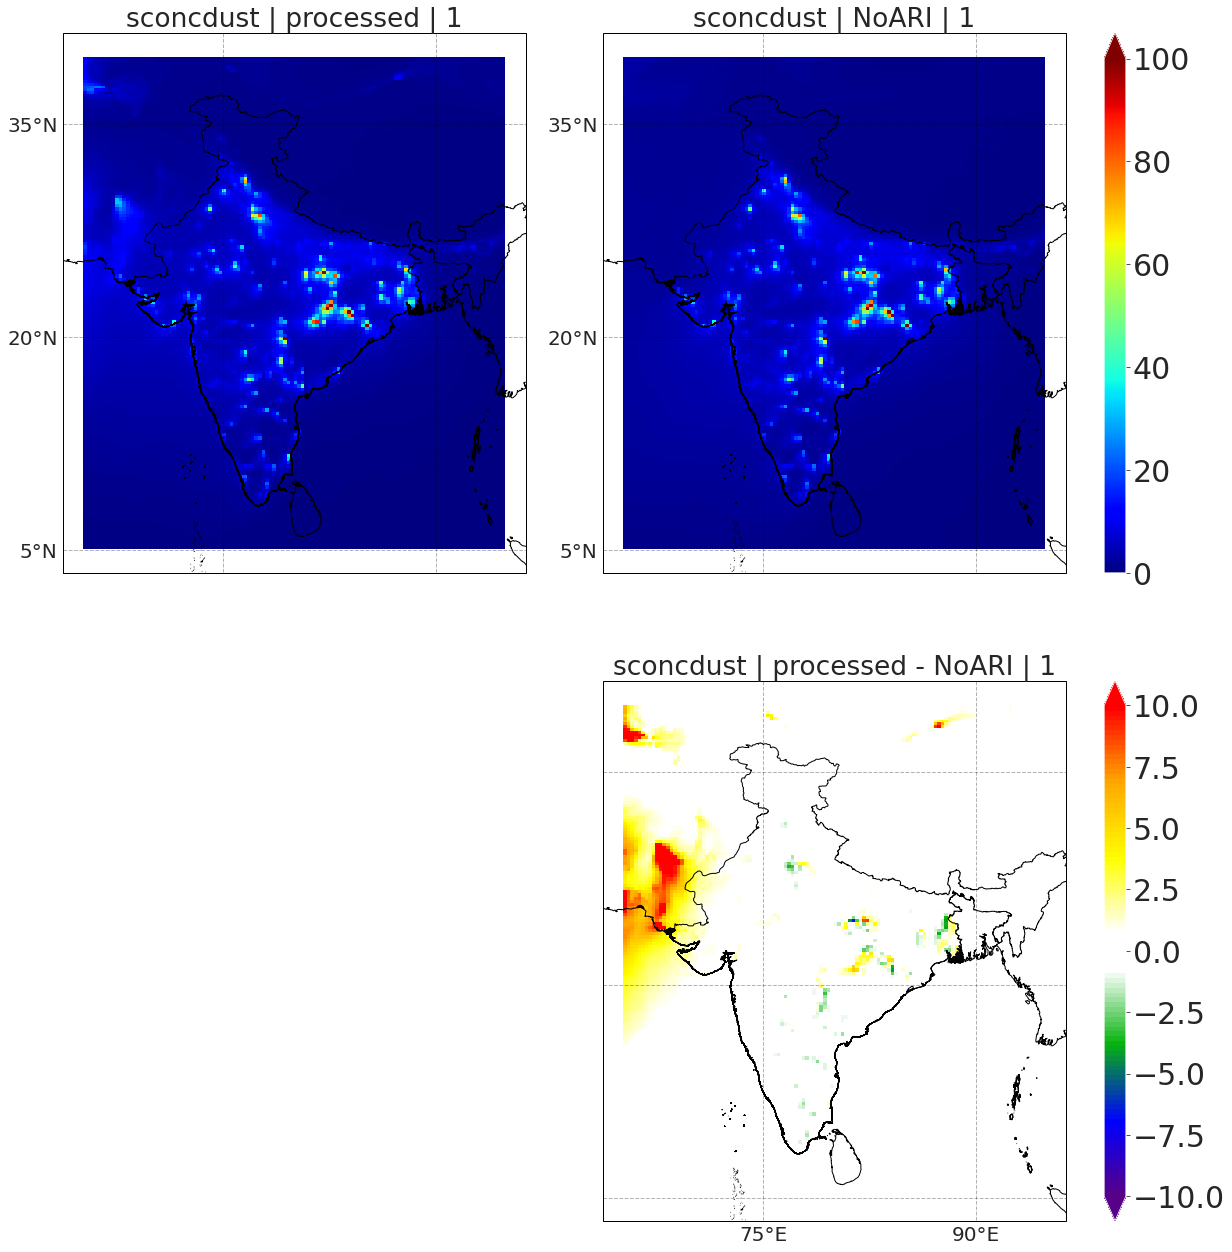

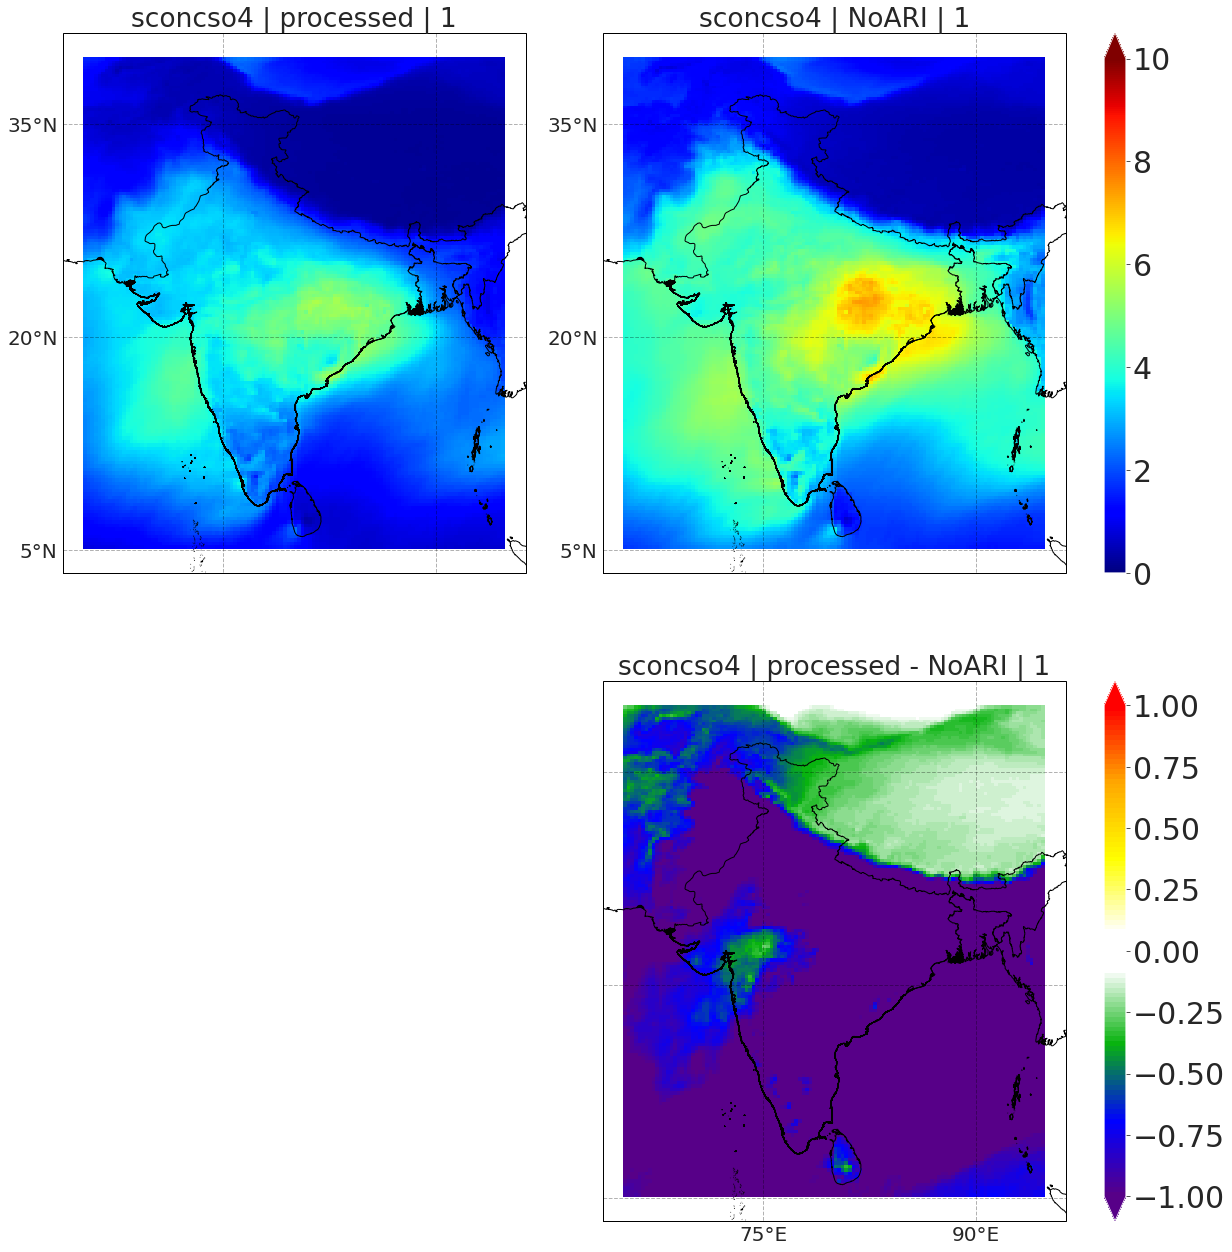

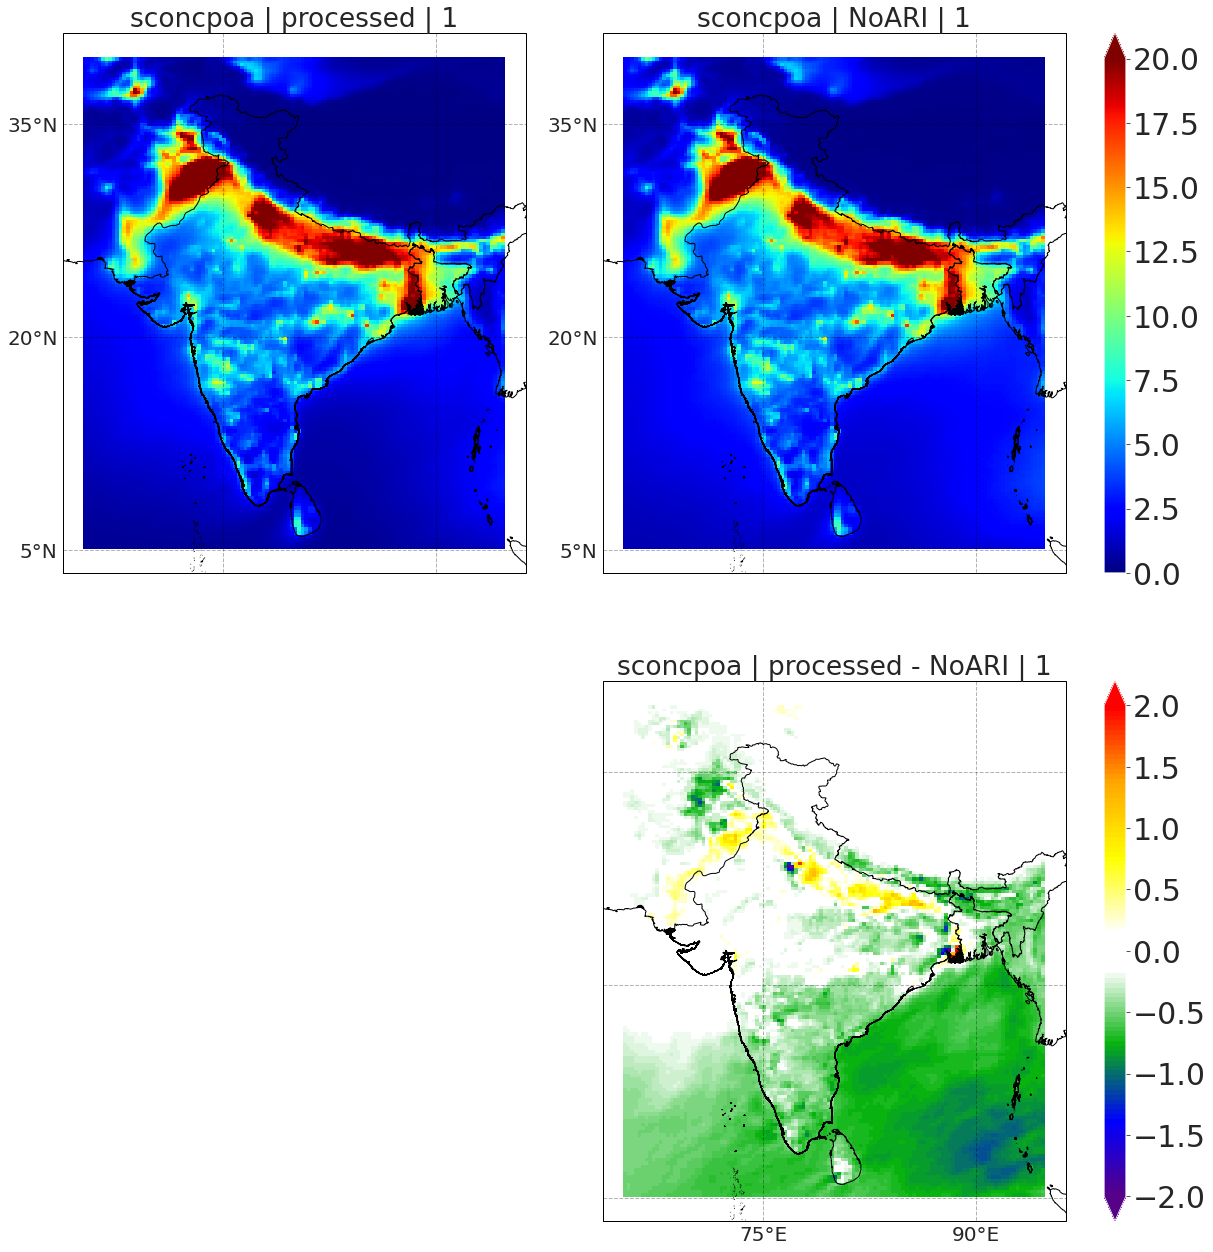

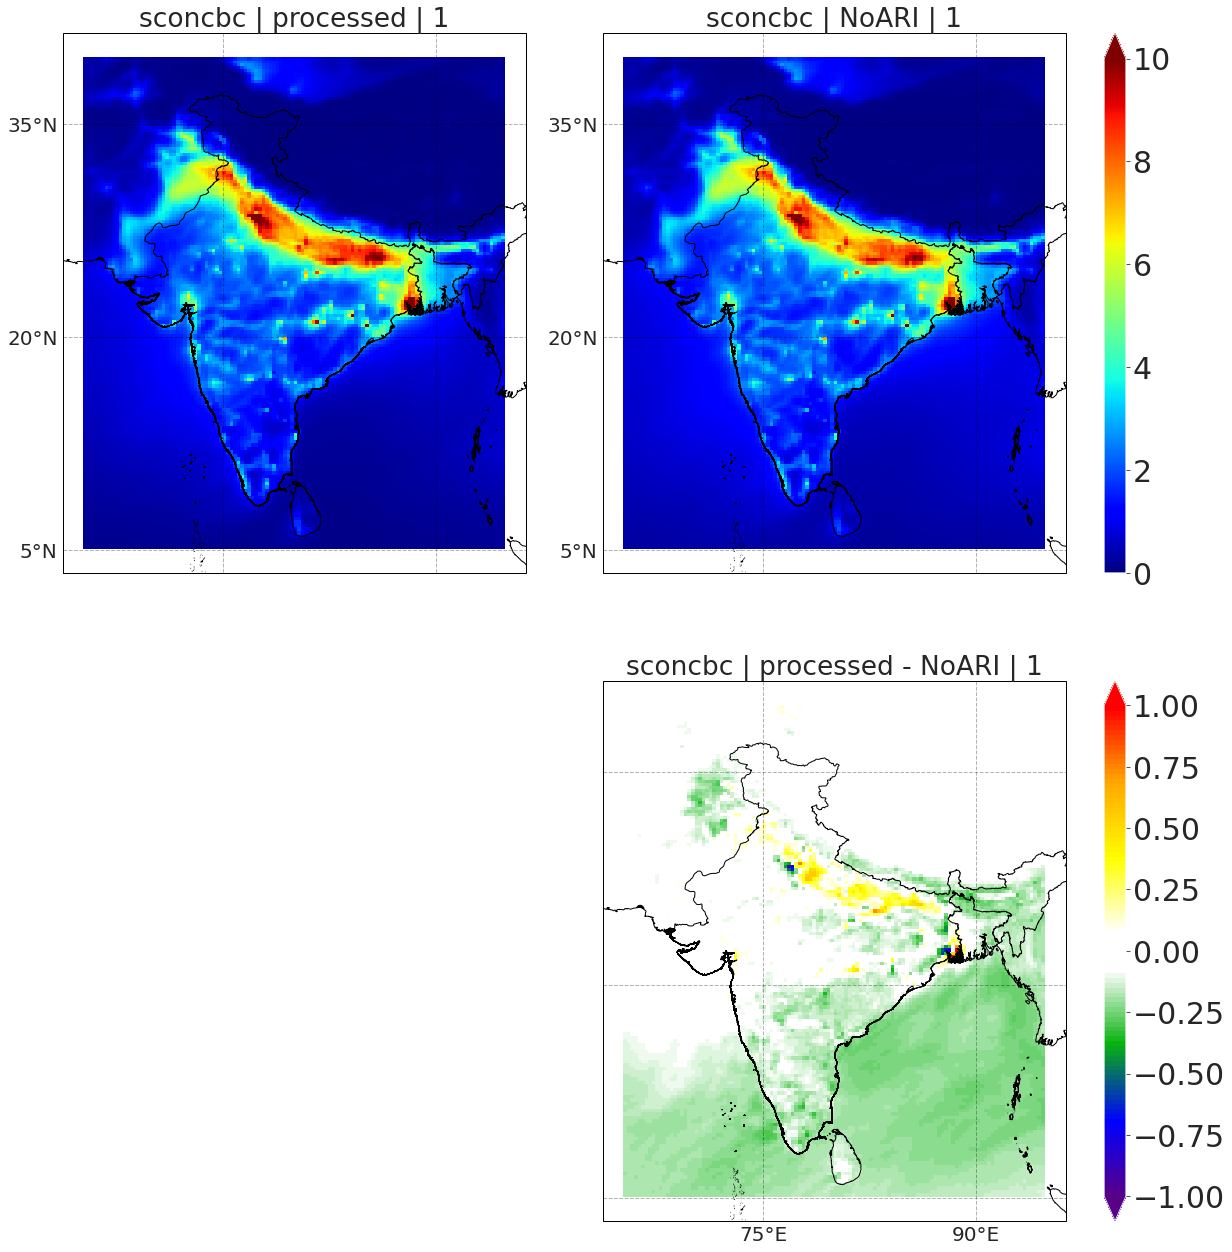

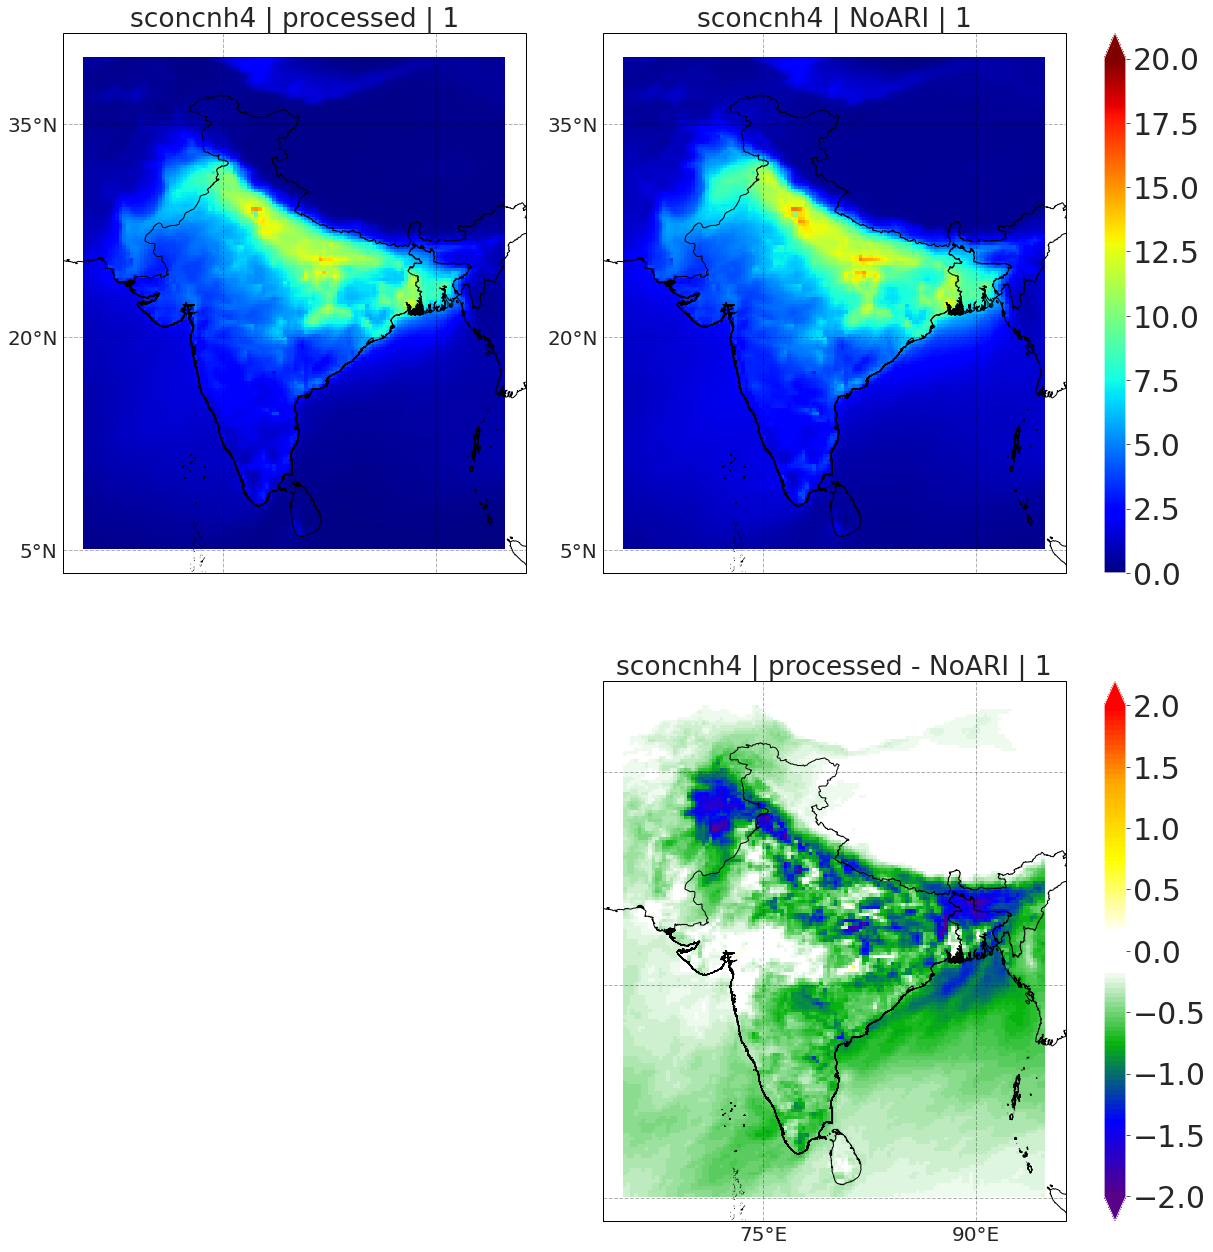

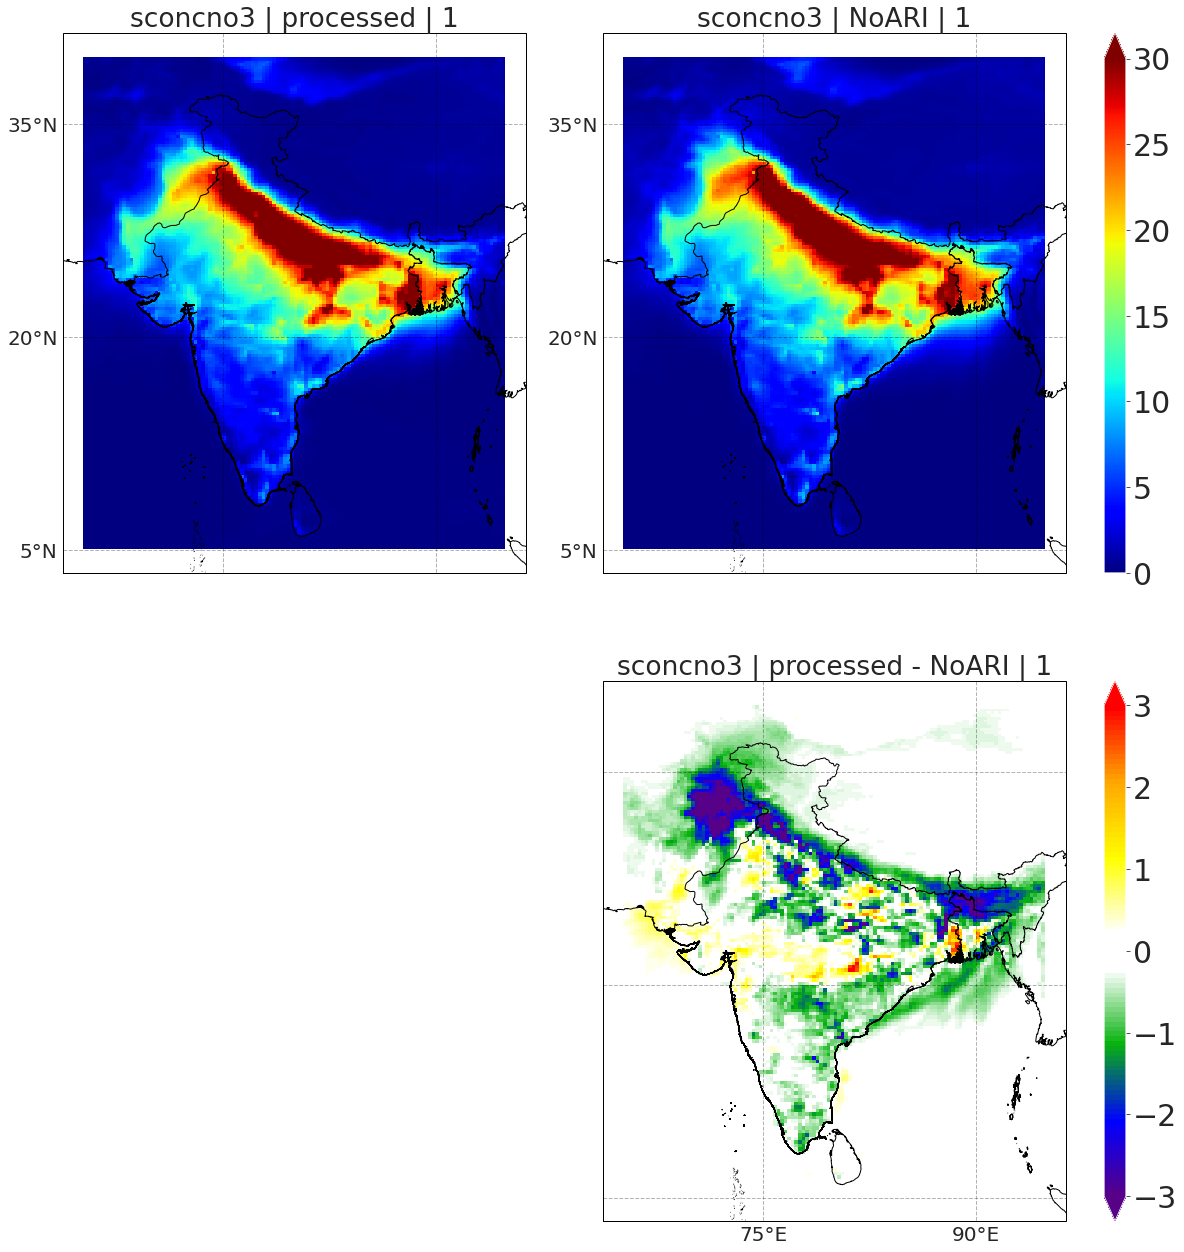

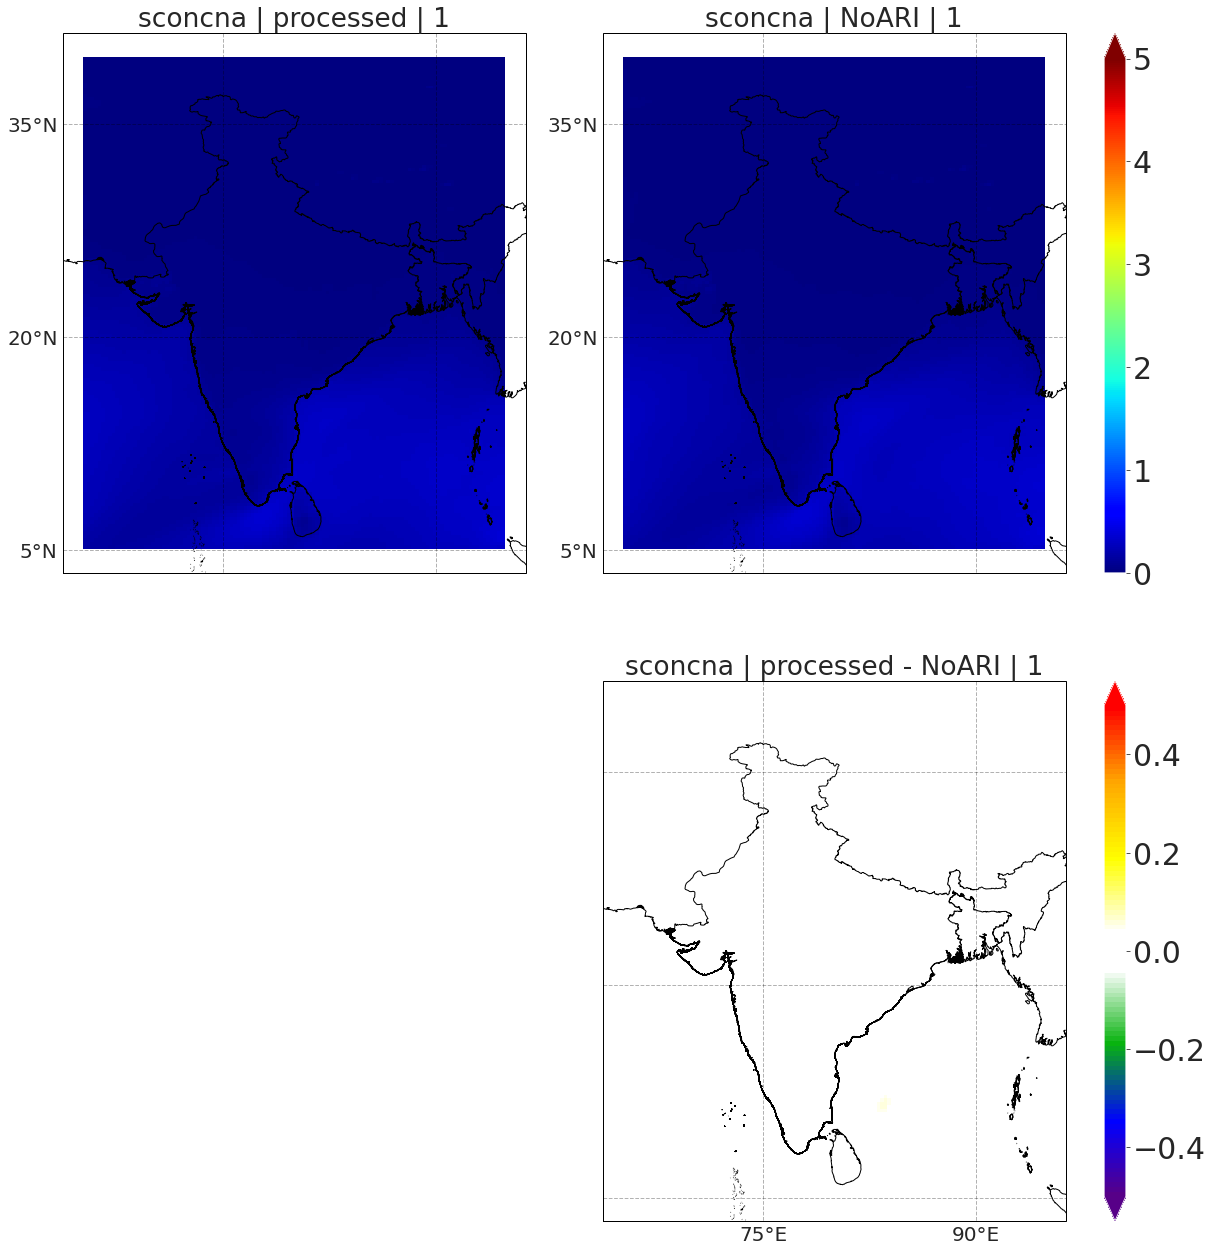

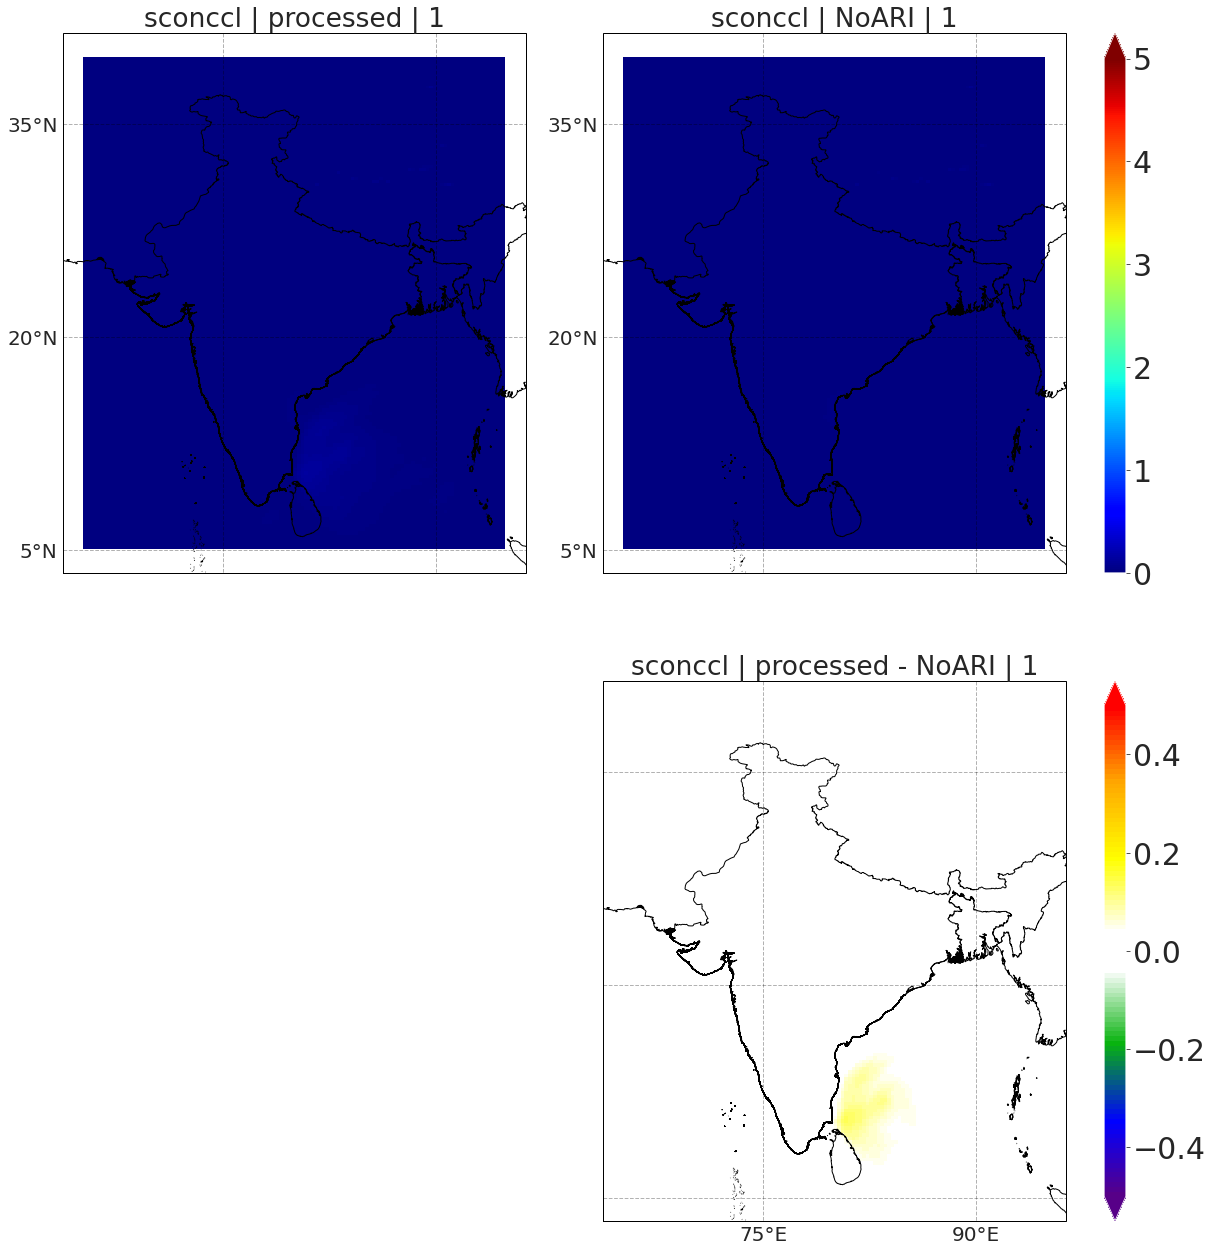

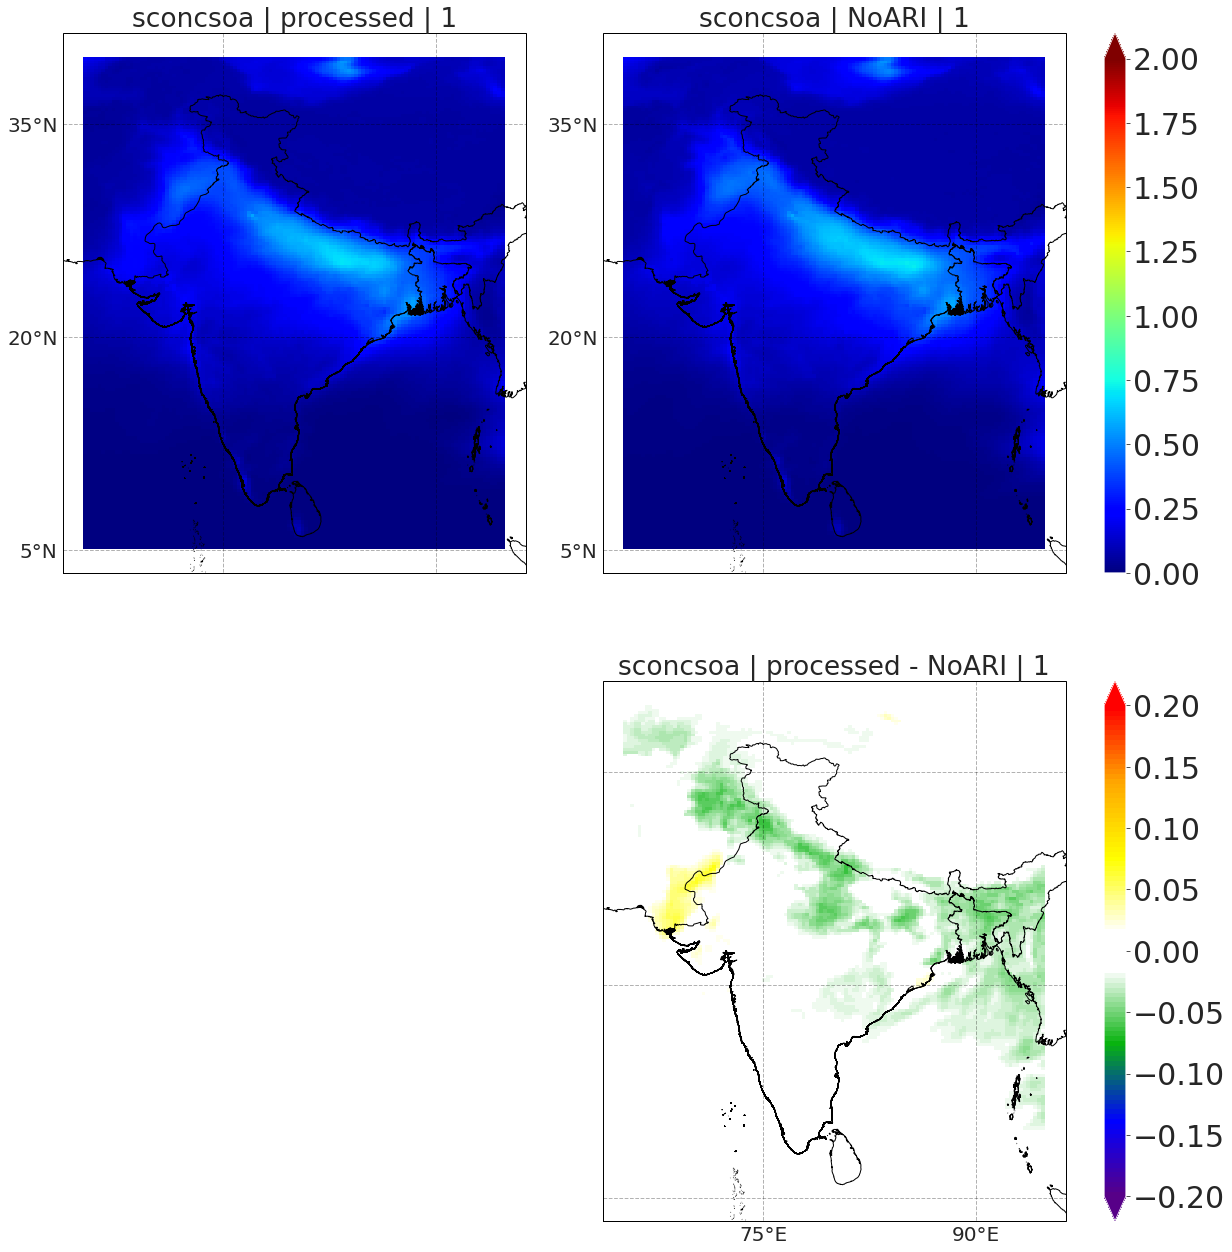

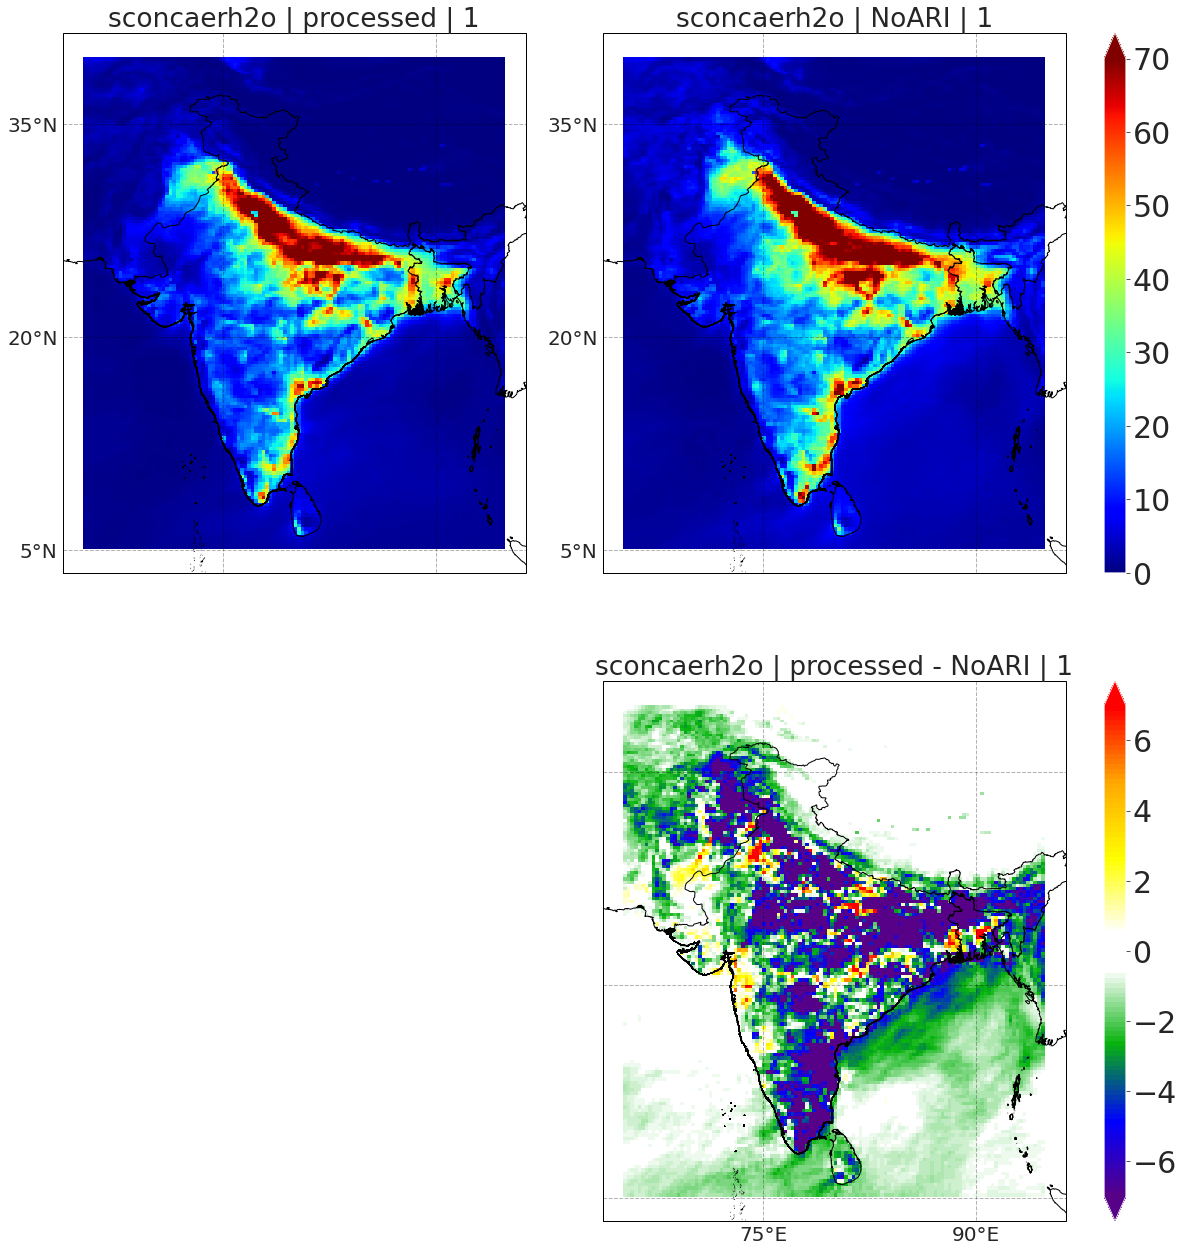

In [73]:
ranspec= {} 
ranspec['sconcdust'] = [0,100]
ranspec['sconcso4'] = [0,10]
ranspec['sconcpoa'] = [0,20]
ranspec['sconcbc'] = [0,10]
ranspec['sconcnh4'] = [0,20]
ranspec['sconcno3'] = [0,30]
ranspec['sconcna'] = [0,5]
ranspec['sconccl'] = [0,5]
ranspec['sconcsoa'] = [0,2]
ranspec['sconcaerh2o'] = [0,70]

spec = {}
for vname_m in ranspec.keys():
    dmap = ['processed','NoARI']

    dset_WRF = ext_WRF(vname_m,dmap)
    
    rmean = ranspec[vname_m]
    rdiff= list(np.array(ranspec[vname_m])/10)
    panel_difference_oModel(dset_WRF*1e9,rmean,rdiff,tp=[1])
    l = {}
    for reg in ['R1','R2','R3','R4','R5','R6']:
        x = timeX(regionX(dset_WRF,reg),1).mean(['time','lat','lon'])
        ARI = (x.isel(exp=0) - x.isel(exp=1)).compute()*1e9
        l[reg] = float(ARI.data)
    spec[vname_m[5:]] = l

In [69]:
ARI_dset = pd.DataFrame(spec)#.transpose()

KeyError: 'R1'

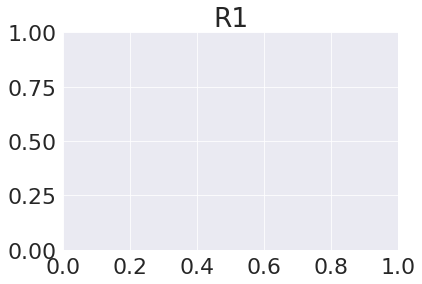

In [70]:
import seaborn as sns
sns.set_style("darkgrid")
for reg in ['R1','R2','R3','R4','R5','R6']:
    plt.figure()
    plt.title(reg)
    ARI_dset[reg].plot.bar()
    plt.ylabel("ug m-3")

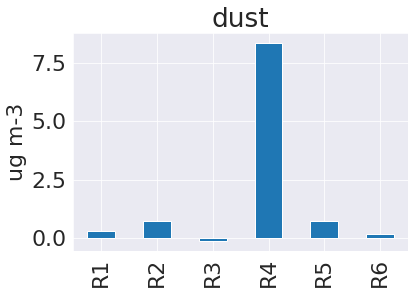

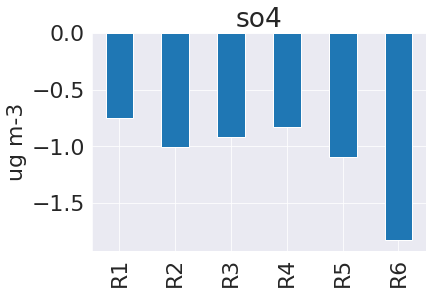

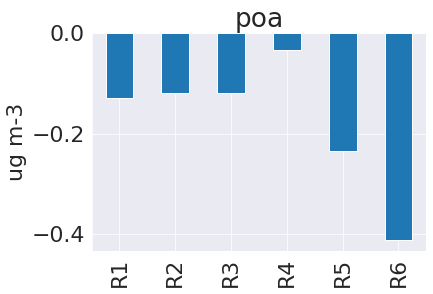

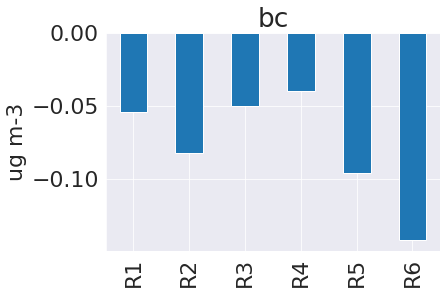

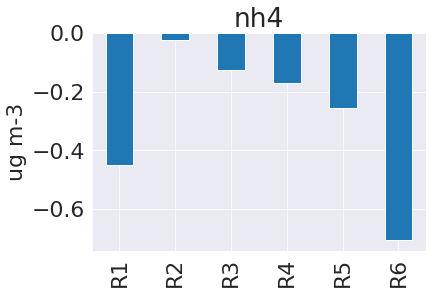

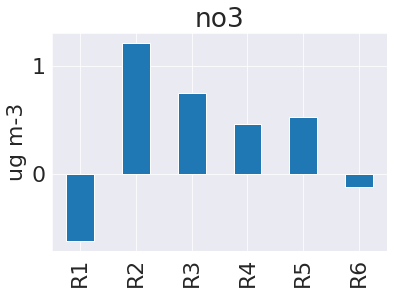

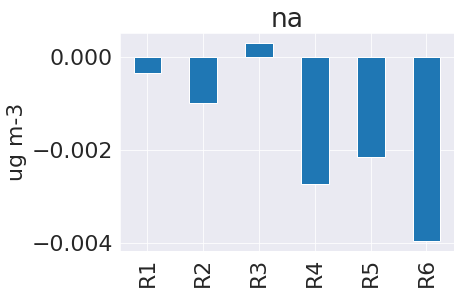

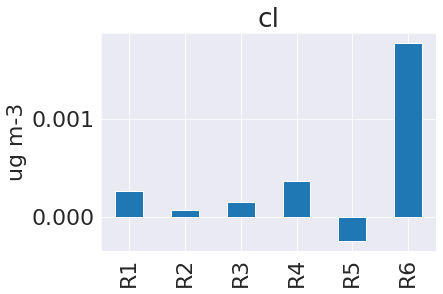

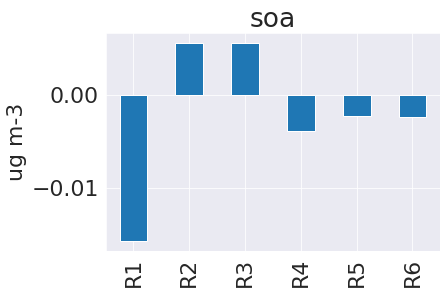

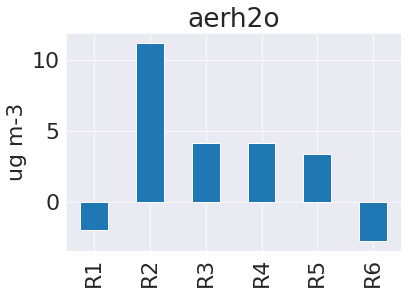

In [72]:
import seaborn as sns
sns.set_style("darkgrid")
for reg in ARI_dset.columns:
    plt.figure()
    plt.title(reg)
    ARI_dset[reg].plot.bar()
    plt.ylabel("ug m-3")

In [71]:
pd.DataFrame(spec)

,dust,so4,poa,bc,nh4,no3,na,cl,soa,aerh2o
R1,0.309370,-0.752122,-0.128113,-0.053849,-0.450336,-0.618136,-0.000328,0.000268,-0.015650,-2.016058
R2,0.726195,-1.002688,-0.118527,-0.082114,-0.022036,1.215806,-0.000992,0.000069,0.005582,11.198360
R3,-0.124610,-0.916849,-0.118556,-0.050202,-0.125894,0.750670,0.000309,0.000149,0.005613,4.167113
R4,8.366468,-0.832202,-0.032692,-0.039398,-0.171440,0.468479,-0.002722,0.000365,-0.003840,4.129366
R5,0.723272,-1.089601,-0.234803,-0.096071,-0.254583,0.524652,-0.002157,-0.000244,-0.002273,3.339917
R6,0.149876,-1.827495,-0.412011,-0.141717,-0.705826,-0.123980,-0.003950,0.001779,-0.002355,-2.757093
